<a href="https://colab.research.google.com/github/opsifiz/AIB5_Mental-Health-Sentiment-Analysis/blob/main/baseline/baseline_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Data Set

In [1]:
import pandas as pd
import json

In [2]:
!gdown https://drive.google.com/uc?id=1aH8KYfnN3l16dLpPpMJgJh3Q0OiaEufo

Downloading...
From: https://drive.google.com/uc?id=1aH8KYfnN3l16dLpPpMJgJh3Q0OiaEufo
To: /content/train_dataset.csv
100% 87.2M/87.2M [00:00<00:00, 145MB/s]


In [3]:
df = pd.read_csv('train_dataset.csv',index_col=False)
#Create Temporay Dataset where each status have 100 texts.
temp = df
temp = temp.groupby('status').head(100)
temp = temp.drop(columns=['from'])
temp['predict'] = '-'
df = temp
df = df.reset_index(drop=True)
df

,text,status,translated,predict
0,oh my gosh,Anxiety,โอ้พระเจ้า!,-
1,trouble sleeping confused mind restless heart ...,Anxiety,นอนไม่หลับ วุ่นวายใจ กระวนกระวายใจ ทุกอย่างดูผ...,-
2,all wrong back off dear forward doubt stay in ...,Anxiety,ทุกอย่างไม่ถูกต้อง ถอยไปเถอะ อย่าก้าวไปข้างหน้...,-
3,i have shifted my focus to something else but ...,Anxiety,ฉันพยายามเบนความสนใจไปเรื่องอื่นแล้ว แต่ก็ยังก...,-
4,i am restless and restless it is been a month ...,Anxiety,ฉันกระวนกระวายใจมาก มันเป็นแบบนี้มาเป็นเดือนแล...,-
...,...,...,...,...
695,hey you all so a few years back i was supposed...,schizophrenia,-,-
696,my friend is too busy dealing with her own men...,schizophrenia,-,-
697,i feel like everything i have gone through in ...,schizophrenia,-,-
698,lately i have had this strange feeling like a ...,schizophrenia,-,-


#Baseline #3

In [5]:
df['status'].value_counts().index

Index(['Anxiety', 'Normal', 'depression', 'bipolar', 'BPD', 'schizophrenia',
       'mentalillness'],
      dtype='object', name='status')

In [4]:
from google import genai

client = genai.Client(api_key='GEMINI_API_KEY')

In [6]:
def gemini_classify(txt):
  #BEGIN PROMPT
  prompt = "You are the best therapist, your work is to define this message that what kind of status is in this message, you can answer only in this following 7 status ['Anxiety', 'Normal', 'depression', 'bipolar', 'BPD', 'schizophrenia', 'mentalillness'] (you can only pick one, dont pick out of this):\n\nmessage : \""+txt+"\"\n\nanswer format : {\"status\" : \"YOUR_ANSWER\"}"
  #END PROMPT
  # print(prompt)
  response = client.models.generate_content(
    model="gemini-2.0-flash-lite",
    contents=prompt,
  )
  return response.text

In [9]:
import time

for i in range(700):
  if(df.iloc[i]['predict'] != '-'):
    continue
  msg = gemini_classify(df.iloc[i]['text'])
  data = json.loads(msg)
  df.at[i, 'predict'] = data['status']
  print(i,data['status'])
  if (i+1)%100 == 0:
    df.to_csv('classify_data_'+str((i+1)//100)+'.csv')
  time.sleep(2)

df.to_csv('classify_data_done.csv')

In [10]:
df.describe()

,text,status,translated,predict
count,700,700,700,700
unique,700,7,300,8
top,it does not help that it is my trauma month in...,Anxiety,-,Anxiety
freq,1,100,400,200


In [11]:
df['predict'].value_counts()

,count
predict,
Anxiety,200
Normal,154
depression,146
BPD,69
schizophrenia,57
bipolar,47
mentalillness,24
Bipolar,3


In [12]:
df.loc[df['predict'] == 'Bipolar', 'predict'] = 'bipolar'

In [13]:
all_status = df['status'].unique()
all_status

array(['Anxiety', 'Normal', 'depression', 'bipolar', 'BPD',
       'schizophrenia', 'mentalillness'], dtype=object)

In [15]:
accuracy = ((df['predict']==df['status']).sum())/1000
print(accuracy)

0.43


<Figure size 800x600 with 0 Axes>

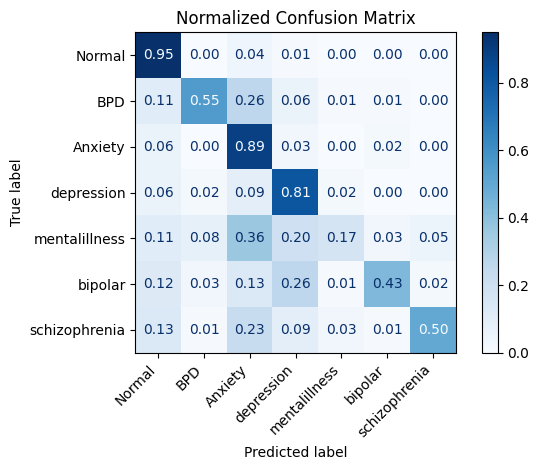

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

candidate_labels = ['Normal','BPD','Anxiety','depression','mentalillness','bipolar','schizophrenia']

# Compute normalized confusion matrix
cm = confusion_matrix(df['status'], df['predict'], labels=candidate_labels, normalize='true')

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=candidate_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format=".2f")
plt.xticks(rotation=45, ha='right')
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()